# Creating custom tools to generate alchemical perturbation networks

OpenFE has built-in atom mappers and network planners to handle common use cases. However, it is relatively easy to create new mappers and planners. This document is aimed at people who are interested in customizing these tools.


## Overview of network creation

Let's create a few molecules just so we have something to play with:

In [1]:
from openfe.setup import SmallMoleculeComponent

LICENSE: Could not open license file "oe_license.txt" in local directory
LICENSE: N.B. OE_LICENSE environment variable is not set
LICENSE: N.B. OE_DIR environment variable is not set
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!


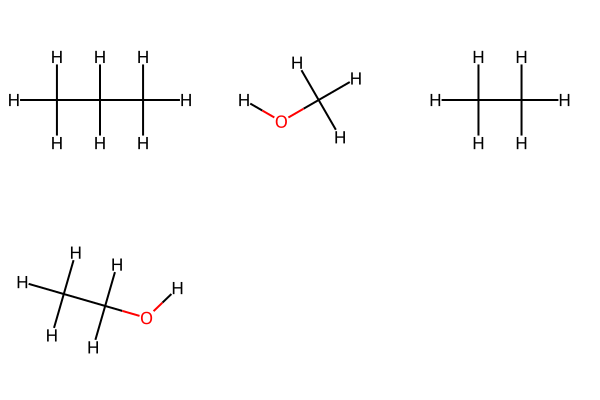

In [2]:
from rdkit import Chem

def component_from_smiles(smiles, name):
    # convenience to get the molecule with hydrogens from no-hydrogen SMILES
    return SmallMoleculeComponent(
        rdkit=Chem.AddHs(Chem.MolFromSmiles(smiles)),
        name=name
    )

propane = component_from_smiles("CCC", "propane")
methanol = component_from_smiles("CO", "methanol")
ethane = component_from_smiles("CC", "ethane")
ethanol = component_from_smiles("CCO", "ethanol")

Chem.Draw.MolsToGridImage([mol.to_rdkit() for mol in [propane, methanol, ethane, ethanol]])

## Creating a custom ligand atom mapper

To create a custom ligand atom mapper, you will make a subclass of `LigandAtomMapper`. The main thing you need to write is a way to get a dictionary description of the atom mapping from the RDKit molecules. The dictionary description of the mapping is a Python `dict` that maps the atom index from the first molecule to that atom's index in the second molecule. Atoms that are either removed or added during the transformation are not part of this dictionary. Atoms that change element are included.

You should consider how you're going to handle the case that your mapper can't create a mapping between two molecules. In these examples, we don't create an edge for those, but we fail silently. That is done by raising and catching a `ValueError` when that occurs.

In these examples, I've written the mapping function as separate from the `LigandAtomMapper` subclass. This is so that I can reuse it in a few examples without copy-pasting that code. You can just as easily directly include the functionality directly in the `_mappings_generator` method in your subclass.

In [3]:
# This is a very silly mapping function, but intended to show a few ideas.
# It maps molecules with 3 heavy atoms to molecules with 2 heavy atoms.
# It includes a parameter to remove the middle atom (if True) or the final atom (if False).

import networkx as nx
from typing import Dict

def my_mapping_function(molA: Chem.Mol, molB: Chem.Mol, remove_middle: bool) -> Dict[int, int]:
    # here remove_middle takes the place of whatever parameters your method takes 
    
    # always be sure to consider the case that your mapping function fails
    if molA.GetNumHeavyAtoms() != 3 or molB.GetNumHeavyAtoms() != 2:
        raise ValueError("Must map from a molecule with 3 heavy atoms to a molecule with 2 heavy atoms.")
    
    # we always map 0: 0, if we remove middle we map 2: 1, 
    if remove_middle:
        mapping = {0: 0, 2: 1}
    else:
        mapping = {0: 0, 1: 1}
    
    # map hydrogens
    # TODO: can't we make a generic function for this?
    # users create the heavy atom mapping; we can get the implied hydrogen mapping
    # def hydrogen_mapping(molA, molB, heavy_mapping)
    hyd_mapping = {}
    graphA = nx.Graph([(b.GetBeginAtomIdx(), b.GetEndAtomIdx()) for b in molA.GetBonds()])
    graphB = nx.Graph([(b.GetBeginAtomIdx(), b.GetEndAtomIdx()) for b in molB.GetBonds()])
    for idxA, idxB in mapping.items():
        hydA = {at for at in graphA.adj[idxA] if molA.GetAtomWithIdx(at).GetAtomicNum() == 1}
        hydB = {at for at in graphB.adj[idxB] if molB.GetAtomWithIdx(at).GetAtomicNum() == 1}
        hyd_mapping.update(zip(hydA, hydB))

    mapping.update(hyd_mapping)
    return mapping

Now we'll wrap this in a `LigandAtomMapper`. Note that the extra parameters in our function (in this case, `remove_middle`) become attributes that we set in the `__init__` method.

In [4]:
from openfe.setup import LigandAtomMapper

class CustomMapper(LigandAtomMapper):
    def __init__(self, remove_middle):
        super().__init__()
        self.remove_middle = remove_middle
    
    def _mappings_generator(self, molA, molB):
        # Note that molA and molB are rdkit.Mol objects, and that you return a list
        try:
            return [my_mapping_function(molA, molB, self.remove_middle)]
        except ValueError:
            return []

The `_mappings_generator` method is used internally; to get the full atom mappings, use the `suggest_mappings` method that you inherit from `LigandAtomMapper`:

In [5]:
mapper = CustomMapper(remove_middle=False)
mappings = list(mapper.suggest_mappings(propane, methanol))
len(mappings)

1

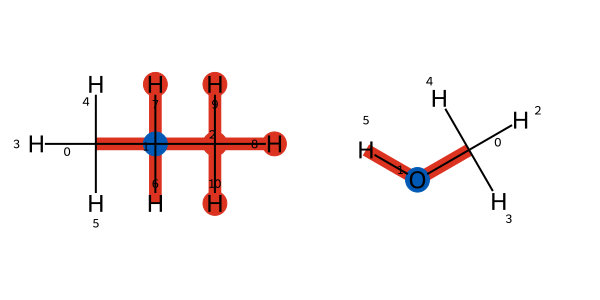

In [6]:
mappings[0]

Red bonds indicate a bond where something has changed. Atoms that are added/removed are highlighted with red dots. Atoms that change element type are marked with a blue dot. You can access the dict that you created with the `mapping.molA_to_molB` attribute:

In [7]:
mappings[0].molA_to_molB

{0: 0, 1: 1, 3: 2, 4: 3, 5: 4, 6: 5}

Bad inputs (meaning unable to form an edge) fail silently here:

In [8]:
list(mapper.suggest_mappings(methanol, propane))

[]

### Returning multiple mappings

OpenFE's `LigandAtomMapper` is designed to return multiple candidate mappings, which may then be scored by a scorer to select the best one. Let's modify the previous code so that instead of setting `remove_middle` to either `True` or `False` in the `__init__`, we have it return both options for that parameter.

In [9]:
class MultiMapper(LigandAtomMapper):
    def _mappings_generator(self, molA, molB):
        mappings = []
        for remove_middle in [True, False]:
            try:
                mappings.append(my_mapping_function(molA, molB, remove_middle))
            except ValueError:
                # if we can't make a mapping, skip to the next iteration in for loop
                continue

        return mappings

In [10]:
mapper = MultiMapper()
mappings = list(mapper.suggest_mappings(propane, methanol))
len(mappings)

2

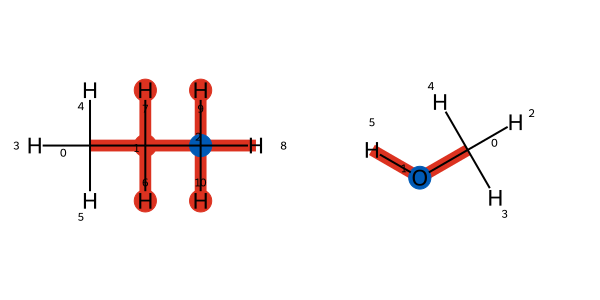

In [11]:
mappings[0]

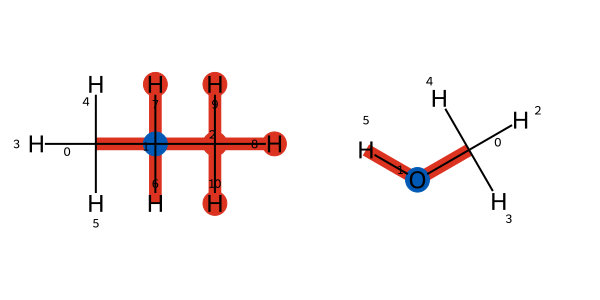

In [12]:
mappings[1]

### Advanced: writing `_mappings_generator` as a generator

In the example above, we wrote `_mappings_generator` so that it returned a list. This will work, and for many workflows, it is a perfectly fine solution. However, there's a more advanced approach to creating a collection of items called [generator functions](https://realpython.com/introduction-to-python-generators/). The advantages of generator functions are that they only create the items you need, and doesn't have to store all of them in memory at once. For example, imagine that you could propose 1000 mappings, and you wanted to keep going until you found one that scored as "good enough." Using a generator function allows you to create them as needed, saving you both CPU time and RAM memory compared to generating the whole list.

Below, we re-implement the `MultiMapper` with `_mappings_generator` as a generator function.

In [13]:
class GeneratorMapper(LigandAtomMapper):
    def _mappings_generator(self, molA, molB):
        for remove_middle in [True, False]:
            try:
                yield my_mapping_function(molA, molB, remove_middle)
            except ValueError:
                # if we can't make a mapping, skip to the next iteration in for loop
                continue

Usage here will look just like the version where you returned a list, but internally it functions more efficiently.

In [14]:
mapper = GeneratorMapper()
mappings = list(mapper.suggest_mappings(propane, methanol))
len(mappings)

2

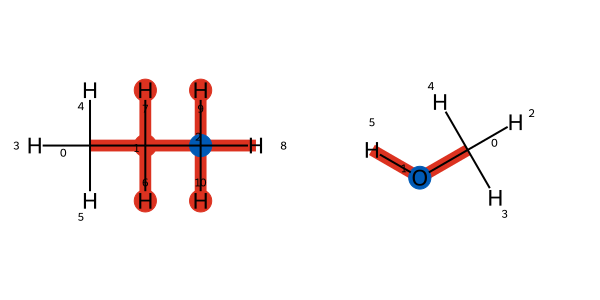

In [15]:
mappings[0]

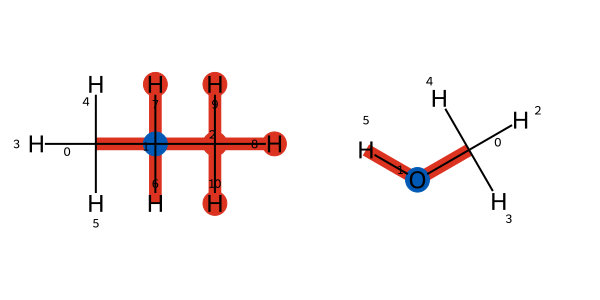

In [16]:
mappings[1]

## Creating a custom network planner

A network planner is a function that uses a mapper on pairs of ligands, and returns the `Network` object. The `Network` can be created for a list of `LigandAtomMapping`s. If you have additional nodes that are not in a mapping, you can add those with the `nodes` keyword.

First let's look at an overly simple network planner. It takes in the ligands and at least one mapper, and returns a `Network`. Sometimes the ligands need to be organized into different variables -- here we need to separate ligands with 3 heavy atoms from those with 2; in a star map, you need to identify which ligand is the central hub. Because of this, the exact call signature of the network planner can differ, but it should always return a `Network`.

In [17]:
import itertools
from openfe.setup import Network

def simple_network_planner(three_heavies, two_heavies, mapper):
    mappings = []
    # loop over all pairs of three-heavy, two-heavy
    for molA, molB in itertools.product(three_heavies, two_heavies):
        for mapping in mapper.suggest_mappings(molA, molB):
            # use all suggested mappings
            mappings.append(mapping)
    
    return Network(mappings)

In [18]:
network = simple_network_planner(
    three_heavies=[propane, ethanol],
    two_heavies=[ethane, methanol],
    mapper=CustomMapper(remove_middle=False),
)

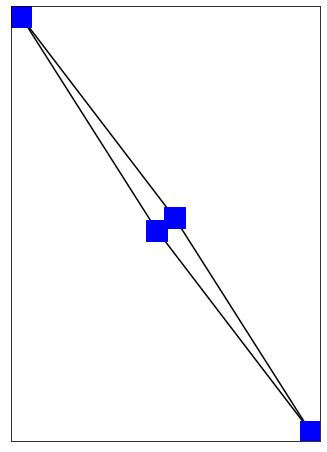

In [19]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network

plot_atommapping_network(network)

The built-in planners in OpenFE allow you to provide multiple mappers, and we recommend structuring your code that way, too. That will allow you to use different mappers, e.g., to handle pathological cases. In many cases, you'll also want a scoring function ("scorer") to select the best mapping (or set of mappings).

Here's a network planner that uses multiple mappers and a scorer. It selects the best mapping (according to the scorer) for each proposed edge.

In [20]:
import itertools
from openfe.setup import Network

def scored_network_planner(three_heavies, two_heavies, mappers, scorer):
    mappings = []
    for molA, molB in itertools.product(three_heavies, two_heavies):
        best_mapping = None
        best_score = float('inf')
        for mapper in mappers:
            for mapping in mapper.suggest_mappings(molA, molB):
                score = scorer(mapping)
                # note that our scorers consider things better if they have a low score
                if score < best_score:
                    # the annotation name here guarantees other parts of OpenFE
                    # can use it too (like visualization tools)
                    # TODO: need with_annotation in this env
                    best_mapping = mapping.with_annotations({'ofe-score': score})
                    best_score = score
        
        mappings.append(best_mapping)
    
    return Network(mappings)

To use this, we need to create our scorer. A scorer is just a function that takes a `LigandAtomMapping` as input and returns a number.

In [21]:
def silly_scorer(mapping):
    # This score is the highest indices of mapped atoms plus the length of the molecule names
    # It shows you how to access this information from the mapping. I wouldn't recommend
    # it for production work.
    molA_to_molB = mapping.molA_to_molB
    highest_indices = max(molA_to_molB.keys()) + max(molA_to_molB.values())
    
    # you'd probably be more likely to access molecule info via mol.to_rdkit()
    name_lengths = sum([len(mol.name) for mol in [mapping.molA, mapping.molB]])
    return name_lengths + highest_indices

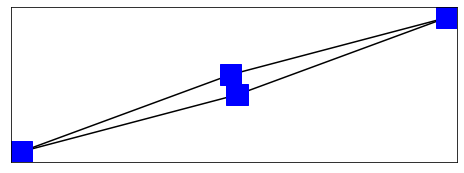

In [22]:
network = scored_network_planner(
    three_heavies=[propane, ethanol],
    two_heavies=[ethane, methanol],
    mappers=[CustomMapper(remove_middle=False)],
    scorer=silly_scorer
)

plot_atommapping_network(network)

You can access the score either from the edge object, or from the NetworkX representation of the network:

In [23]:
# from the edge itself
an_edge = next(iter(network.edges))
an_edge.annotations['ofe-score']

26

In [24]:
# from NetworkX
nx_graph = network.graph
nx_graph[propane][methanol][0]['ofe-score']
# we need the 0 because this is a MultiGraph: you can have more than one edge per node pair

26

## Using multiple mappers in a planner

There may be cases where you want to try different atom mapping strategies.

In [25]:
# TODO: fill this in

## Creating a network completely from scratch

Let's say that you already know which edges you want and what the atom mapping dictionaries are. In that case, it is straightforward (although possibly tedious) to hand-craft a network. All the machinery of atom mappers and network planners exists just to simplify this process.

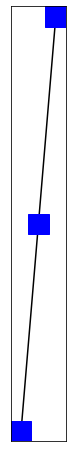

In [26]:
from openfe.setup import LigandAtomMapping

propane_to_ethane_dict = {0: 0, 1: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}
propane_to_methanol_dict = {0: 0, 1: 1, 3: 2, 4: 3, 5: 4, 6: 5}
custom_network = Network([
    LigandAtomMapping(propane, ethane, propane_to_ethane_dict),
    LigandAtomMapping(propane, methanol, propane_to_methanol_dict)
])

plot_atommapping_network(custom_network)

## "Editing" an existing network

What if you have a network, but just want to add or remove some edges? Technically, our networks are immutable, so they can't be changed. However, you can create a new network based on the old one, with the modifications you want. We even have a convenient tool to add edges/nodes if you need to.

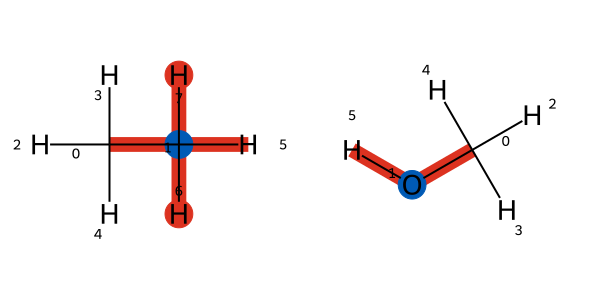

In [27]:
# our atom mapper can't handle this, so we add a custom edge
ethane_to_methanol = LigandAtomMapping(
    ethane,
    methanol,
    {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
)
ethane_to_methanol

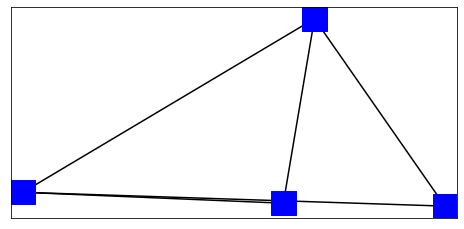

In [28]:
new_network = network.enlarge_graph(edges=[ethane_to_methanol])

plot_atommapping_network(new_network)